In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as Dataset
import torchvision.transforms as Transforms
import matplotlib.pyplot as plt
from tqdm import tqdm


import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
NUM_EPOCH = 2
NUM_CLASSES = 47
BATCH_SIZE = 64
LEARNING_RATE = 0.01

### Dataset

In [3]:
#Download the dataset
train_dataset = Dataset.EMNIST(root="./data", train=True, transform=Transforms.ToTensor(), split="balanced", download=True)
test_dataset = Dataset.EMNIST(root="./data", train=False, transform=Transforms.ToTensor(), split="balanced", download=True)

100%|██████████| 561753746/561753746 [05:34<00:00, 1679617.22it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


In [35]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [36]:
# Normalize the dataset
mean = 0.0
std = 0.0
num_samples = 0


for data, lbls in train_loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    num_samples += batch_samples

mean /= num_samples
std /= num_samples

print(f'{mean=}; {std=}; {num_samples=}')

normalize_transform = Transforms.Normalize(mean=mean, std=std)

# Apply normalization to train and test datasets
train_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])

test_loader.transform = Transforms.Compose([
    Transforms.ToTensor(),
    normalize_transform
])



mean=tensor([-6.5242e-07]); std=tensor([1.0000]); num_samples=112800


In [38]:
for data, label in train_loader:
    # Print the shape of the data tensor
    print("Data shape:", data)
    
    # Print the label
    print("Label:", label)  # label is a tensor, so use .item() to get the integer value
    
    # Break after printing one sample
    break

Data shape: tensor([[[[-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          ...,
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360]]],


        [[[-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          ...,
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360]]],


        [[[-0.5360, -0.5360, -0.5360,  ..., -0.5360, -0.5360, -0.5360],
          [-0.

number of classes 47


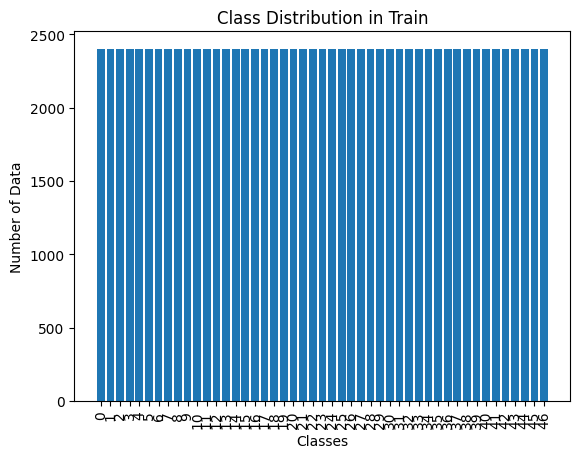

In [26]:
class_counts = {}

for values, labels in train_loader:
    for label in labels:
        if label.item() in class_counts:
            class_counts[label.item()] += 1
        else:
            class_counts[label.item()] = 1

classes = list(class_counts.keys())
counts = list(class_counts.values())
print(f'number of classes {len(classes)}')
NUM_CLASSES = len(classes)

# Plotting graph
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Data')
plt.title('Class Distribution in Train')
plt.xticks(classes)
plt.xticks(rotation=90)
plt.show()

In [22]:
VGG16 = [64, 64, 'M', 128,128,'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

In [23]:
class VGGNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1000, architecture=VGG16):
        super(VGGNet, self).__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layer(VGG16)
        self.fcs = nn.Sequential(
            nn.Linear(512*7*7, 4096), # size of feature map at end is 7*7
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096,num_classes)
        )
        self.softMax = nn.Softmax(dim=1) # not sure


    def forward(self, x):
        out = self.conv_layers(x)
        out = out.reshape(out.shape[0], -1)
        out = self.fcs(out)
        out = self.softMax(out)
        return out

    def create_conv_layer(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3),stride=(1,1), padding=(1,1)),
                           nn.BatchNorm2d(x),
                           nn.ReLU()]
                
                in_channels = x
            elif x == 'M':
                layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

        return nn.Sequential(*layers)
        


In [47]:
model = VGGNet(architecture=VGG16,in_channels=1, num_classes=NUM_CLASSES).to(device)
# model

In [32]:
def test():
    x = torch.randn(2, 3, 224, 224)
    print(x.shape)

    result = model(x.to(device))
    return result

fp = test()
fp

torch.Size([2, 3, 224, 224])


tensor([[0.0239, 0.0228, 0.0265, 0.0183, 0.0220, 0.0163, 0.0131, 0.0119, 0.0208,
         0.0270, 0.0194, 0.0291, 0.0260, 0.0260, 0.0211, 0.0214, 0.0128, 0.0184,
         0.0155, 0.0163, 0.0291, 0.0184, 0.0176, 0.0241, 0.0231, 0.0136, 0.0194,
         0.0220, 0.0210, 0.0188, 0.0212, 0.0327, 0.0207, 0.0186, 0.0245, 0.0275,
         0.0250, 0.0190, 0.0184, 0.0263, 0.0242, 0.0200, 0.0219, 0.0223, 0.0195,
         0.0199, 0.0226],
        [0.0264, 0.0175, 0.0228, 0.0186, 0.0208, 0.0194, 0.0180, 0.0200, 0.0281,
         0.0238, 0.0241, 0.0272, 0.0221, 0.0280, 0.0228, 0.0133, 0.0160, 0.0222,
         0.0164, 0.0162, 0.0324, 0.0291, 0.0214, 0.0170, 0.0189, 0.0205, 0.0233,
         0.0181, 0.0168, 0.0201, 0.0181, 0.0306, 0.0113, 0.0216, 0.0168, 0.0174,
         0.0203, 0.0213, 0.0214, 0.0255, 0.0191, 0.0217, 0.0226, 0.0178, 0.0267,
         0.0197, 0.0265]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [48]:
def train(model, epochs, criterion, optimizer, scheduler):
    train_losses = []
    train_acc = []

    for i in range(epochs):
        best_acc = 0.0

        print(f"Epoch: {i + 1}")

        for images, targets in tqdm(train_loader, desc= "Train\t"):
            images, targets = images.to(device), targets.to(device)

            # images = images.reshape(images.shape[0], -1) 

            optimizer.zero_grad()

            output = model(images)
            loss = criterion(output, targets)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            pred = torch.argmax(output, dim=1)
            running_correct += (pred == targets).sum().item()
            total += targets.size(0)
            
        scheduler.step()

        train_losses.append(running_loss / len(trainloader))
        train_acc.append(running_correct / total)

    return train_losses, train_acc
            

In [49]:
# optimizer and loss and scheduler

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCH, eta_min=0.001)

In [50]:
train_losses, train_acc = train(model,NUM_EPOCH,criterion,optimizer,scheduler )

Epoch: 1


Train	:   0%|          | 0/1763 [00:00<?, ?it/s]


RuntimeError: Given input size: (512x1x1). Calculated output size: (512x0x0). Output size is too small